In [13]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt

# Conexión con BigQuery

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="maximal-brace-365422-c5d5eb0f1996.json"


In [5]:
# Construct a BigQuery client object.
client = bigquery.Client()

query = """
    SELECT * 
    FROM `bigquery-public-data.imdb.reviews` as reviews
    INNER JOIN `bigquery-public-data.imdb.title_basics` as titles
    ON reviews.movie_id = titles.tconst
"""
df = client.query(query).to_dataframe()  # Make an API request.


# Análisis de datos
El dataset que se esocogio fue el de IMDB, del cual seleccionamos dos tablas: reviews y title_basics las cuales se relacionan por medio de la columna movie_id y tconst.
Como resultado tenemos un dataset de 94674 filas y 16 columnas previo a su limpieza.
Respecto a cada columna tenemos:
1. Reviews: hace referencia a la review de cierta pelicula/Serie/show/etc realizada por un usuario
2. split: etiquta la fila para pertenecer a un subconjuto de datos: train y test, para posteriormente ser entrenada en un modelo de machine learning
3. label: Etiqueta que le asigna la polaridad de la review realizada(Positiva o negativa)
4. movie_id: caracter alfanumerico que identifica el producto audiovisual
5. reviewer_rating: El rating que le dio la persona que realizó la review 
6. movie_url: url para ver la información de la película en imdb 
7. title: titulo de la pelicula 
8. tconst: caracter alfanumerico que identifica el producto audiovisual
9. title_type: tipo de producto audiovisual: serie, pelicula, short, tvshow, etc
10. primary_title: El titulo mas popular.
11. original_title: El titulo original en el idioma original
12. is_adult: Si la pellicula es para adultos o no
13. start_year: Año de lanzamiento
14. end_year: año en que termino en caso de ser una serie o show
15. runtime_minutes: tiempo de duración
16. genres: Generos a losque pertenece la pelicula 
 

In [4]:
#Los tipos de datos se encuentran a continuacion donde object hace referencia a string, int a entero
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94674 entries, 0 to 94673
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           94674 non-null  object
 1   split            94674 non-null  object
 2   label            94674 non-null  object
 3   movie_id         94674 non-null  object
 4   reviewer_rating  47285 non-null  Int64 
 5   movie_url        94674 non-null  object
 6   title            94673 non-null  object
 7   tconst           94674 non-null  object
 8   title_type       94674 non-null  object
 9   primary_title    94674 non-null  object
 10  original_title   94674 non-null  object
 11  is_adult         94674 non-null  Int64 
 12  start_year       94669 non-null  Int64 
 13  end_year         4834 non-null   Int64 
 14  runtime_minutes  93779 non-null  Int64 
 15  genres           94628 non-null  object
dtypes: Int64(5), object(11)
memory usage: 12.0+ MB


In [5]:
#diferentes tipos de formatos audiovisuales, solo nos interesan las peliculas
df['title_type'].value_counts()

movie           74754
tvMovie          5788
video            4835
tvSeries         4104
short            1675
tvMiniSeries     1502
tvEpisode        1241
videoGame         385
tvSpecial         334
tvShort            56
Name: title_type, dtype: int64

In [6]:
#Dimensión del dataset luego de solo elegir las peliculas
df_movies = df.loc[df['title_type'] == 'movie'].reset_index(drop=True)

print(f'''Dimensión del dataset: {df_movies.shape}
            Numero de columnas: {df_movies.shape[1]}
            Numero de filas: {df_movies.shape[0]}''')

Dimensión del dataset: (74754, 16)
            Numero de columnas: 16
            Numero de filas: 74754


In [7]:
#Columnas a eliminar: tconst, movie_url, title_type, end_year, 'original_title, title ya que no nos aportan informacion
df_movies.head()

review split     label  \
0  hair, the movie based on the broadway hit,fail...  test  Negative   
1  This film is an insult to the play upon which ...  test  Negative   
2  I should start off by saying I have something ...  test  Negative   
3  I've liked Milos Forman's movies since I saw "...  test  Negative   
4  I was a hippie age 22 in 1965, have seen the p...  test  Negative   

    movie_id  reviewer_rating                             movie_url title  \
0  tt0079261                4  http://www.imdb.com/title/tt0079261/  Hair   
1  tt0079261                1  http://www.imdb.com/title/tt0079261/  Hair   
2  tt0079261                4  http://www.imdb.com/title/tt0079261/  Hair   
3  tt0079261                4  http://www.imdb.com/title/tt0079261/  Hair   
4  tt0079261                1  http://www.imdb.com/title/tt0079261/  Hair   

      tconst title_type primary_title original_title  is_adult  start_year  \
0  tt0079261      movie          Hair           Hair         0        1979   
1  tt0079261      movie          Hair           Hair         0        1979   
2  tt0079261      movie          Hair           Hair         0        1979   
3  tt0079261      movie          Hair           Hair         0        1979   
4  tt0079261      movie          Hair           Hair         0        1979   

   end_year  runtime_minutes                genres  
0      <NA>              121  Comedy,Drama,Musical  
1      <NA>              121  Comedy,Drama,Musical  
2      <NA>              121  Comedy,Drama,Musical  
3      <NA>              121  Comedy,Drama,Musical  
4      <NA>              121  Comedy,Drama,Musical

In [7]:
df_movies.drop(['tconst', 'movie_url', 'title_type', 'end_year', 'title', 'original_title'], axis=1, inplace=True)
df_movies.head()



review  split     label  \
0  This movie was exactly what I expected, not gr...  train  Negative   
1  I am a huge, huge fan of John Cusack, Samuel L...  train  Negative   
2  '1408' is the latest hodge podge of cheap scar...  train  Negative   
3  I don't see what everyone liked about this mov...  train  Negative   
4  After spotting the high rating on IMDb, I deci...  train  Negative   

    movie_id  reviewer_rating primary_title  is_adult  start_year  \
0  tt0450385                3          1408         0        2007   
1  tt0450385                4          1408         0        2007   
2  tt0450385                1          1408         0        2007   
3  tt0450385                1          1408         0        2007   
4  tt0450385                2          1408         0        2007   

   runtime_minutes                  genres  
0              104  Fantasy,Horror,Mystery  
1              104  Fantasy,Horror,Mystery  
2              104  Fantasy,Horror,Mystery  
3              104  Fantasy,Horror,Mystery  
4              104  Fantasy,Horror,Mystery

# Visualizations

### ¿Influye la duración de las películas en la opinión que tienen las personas?

In [9]:
# Eliminar filas en las que la columna 'review_rating es nula'
df_not_null_rating = df_movies.dropna(axis=0, subset=['reviewer_rating'])
# Agrupar por duración y promediar la calificación
df_unique_duration = df_not_null_rating.groupby(['runtime_minutes']).mean().round()
df_unique_duration.reset_index(inplace=True)
df_unique_duration

C:\Users\Pablo Tamayo\AppData\Local\Temp\ipykernel_14540\3551438408.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_unique_duration = df_not_null_rating.groupby(['runtime_minutes']).mean().round()


runtime_minutes  reviewer_rating  is_adult  start_year
0                 41              8.0       0.0      1943.0
1                 45              6.0       0.0      1924.0
2                 47              9.0       0.0      1983.0
3                 48             10.0       0.0      1967.0
4                 50              7.0       0.0      1998.0
..               ...              ...       ...         ...
152              263              1.0       0.0      1949.0
153              275              9.0       0.0      1979.0
154              278              3.0       0.0      2004.0
155              345              3.0       0.0      2000.0
156              453              2.0       0.0      1965.0

[157 rows x 4 columns]

<AxesSubplot: title={'center': 'runtime_minutes'}, xlabel='reviewer_rating'>

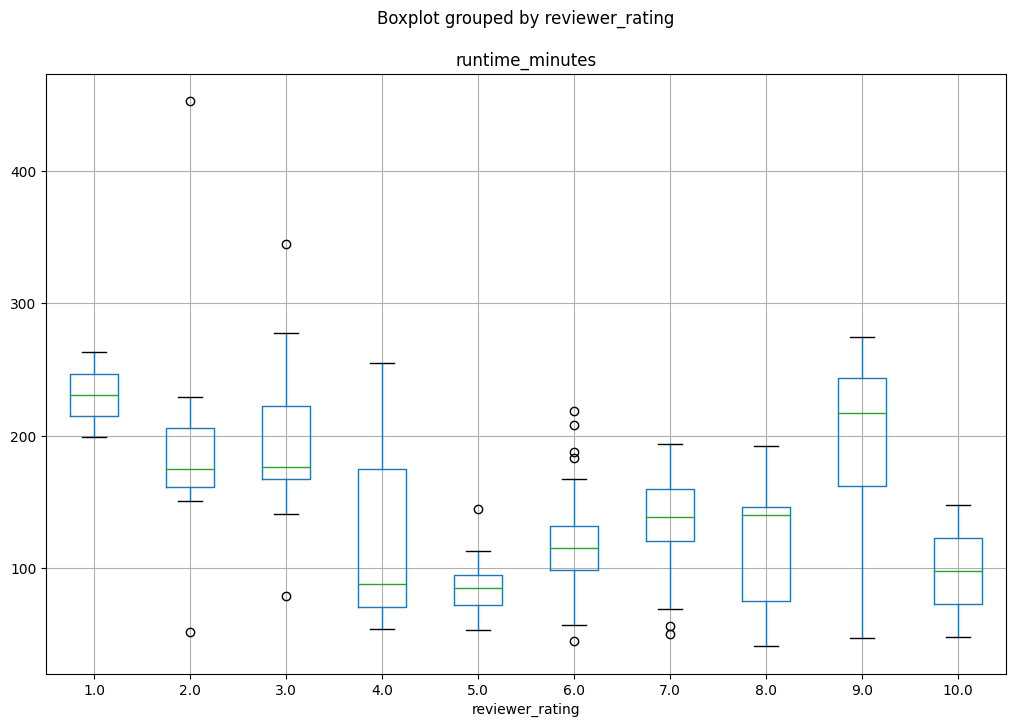

In [10]:
# Visualizar la relación entre el rating y el tiempo de duración
df_unique_duration.boxplot(column='runtime_minutes', by='reviewer_rating',figsize=(12,8))

### ¿Qué géneros tienen mejores ratings?

In [11]:
# Agrupar por géneros y promediar la calificación
df_unique_genre = df_not_null_rating.groupby(['genres']).mean().round()
df_unique_genre.reset_index(inplace=True)
df_unique_genre

C:\Users\Pablo Tamayo\AppData\Local\Temp\ipykernel_14540\2561718631.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_unique_genre = df_not_null_rating.groupby(['genres']).mean().round()


genres  reviewer_rating  is_adult  start_year  \
0                        Action              4.0       0.0      1995.0   
1              Action,Adventure              4.0       0.0      1979.0   
2    Action,Adventure,Animation              6.0       0.0      1999.0   
3    Action,Adventure,Biography              6.0       0.0      2003.0   
4       Action,Adventure,Comedy              4.0       0.0      1997.0   
..                          ...              ...       ...         ...   
450                Thriller,War              6.0       0.0      1942.0   
451            Thriller,Western              1.0       0.0      2007.0   
452                         War              5.0       0.0      1985.0   
453                 War,Western              3.0       0.0      1968.0   
454                     Western              5.0       0.0      1966.0   

     runtime_minutes  
0               92.0  
1               96.0  
2               97.0  
3              110.0  
4              102.0  
..               ...  
450             99.0  
451             90.0  
452            112.0  
453            125.0  
454             92.0  

[455 rows x 5 columns]

In [12]:
# Inicializar una lista para guardar los géneros
simple_genres =[]
# Recorrer los conjuntos de géneros de las películas
for genre in df_unique_genre['genres']:
    # Separar los géneros de cada película
    for simple_genre in genre.split(','):
        # Agregar el género a la lista
        if simple_genre not in simple_genres:
            simple_genres.append(simple_genre)
# Organizar la lista de géneros
simple_genres.sort()

# Inicializar un diccionario para guardar los promedios de calificación por género
genres_rating = {}
# Recorrer la lista de géneros individuales
for genre in simple_genres:
    # Inicializar una lista para guardar las calificaciones de cada género
    ratings = []
    for i in range(len(df_unique_genre)):
        # Si el género está en el conjunto de géneros de la película
        if genre in df_unique_genre['genres'][i]:
            # Agregar la calificación de la película a la lista
            ratings.append(df_unique_genre['reviewer_rating'][i])
    # Calcular el promedio de las calificaciones de cada género
    genres_rating[genre] = (sum(ratings) / len(ratings)).round(2)

genres_rating


{'Action': 4.72,
 'Adult': 3.57,
 'Adventure': 5.09,
 'Animation': 5.43,
 'Biography': 5.42,
 'Comedy': 5.1,
 'Crime': 5.15,
 'Documentary': 5.81,
 'Drama': 5.38,
 'Family': 5.35,
 'Fantasy': 4.98,
 'Film-Noir': 4.21,
 'History': 5.73,
 'Horror': 3.97,
 'Music': 5.59,
 'Musical': 6.03,
 'Mystery': 4.96,
 'News': 2.0,
 'Romance': 5.05,
 'Sci-Fi': 4.6,
 'Short': 8.0,
 'Sport': 5.61,
 'Thriller': 4.55,
 'War': 5.66,
 'Western': 4.59}

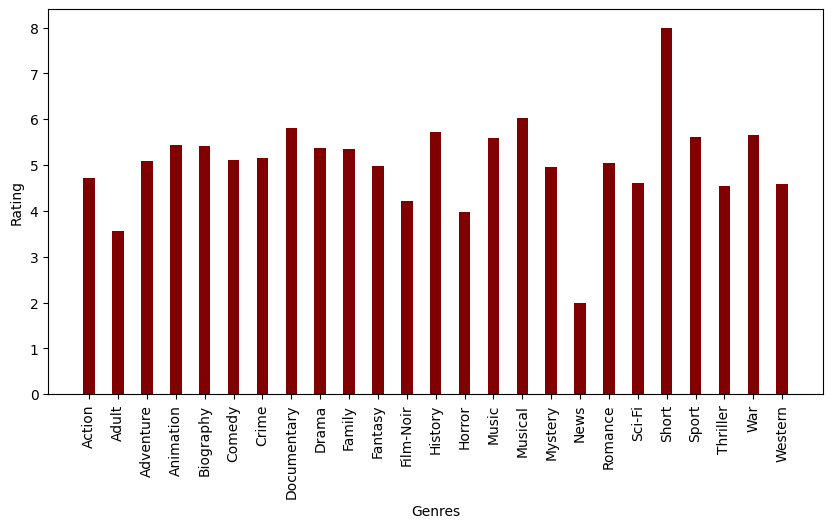

In [13]:
# Visualizar la relación entre el rating y el género

genres = list(genres_rating.keys())
rating = list(genres_rating.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(genres, rating, color ='maroon',
        width = 0.4)

plt.xlabel("Genres")
plt.xticks(rotation=90)
plt.ylabel("Rating")
plt.show()

Se puede observar que el género de "Cortos" es el que tiene una mayor puntuación, mientras que el género de "Noticias" tiene una puntuación muy baja.

### Relacion reviews negativas vs reviews positivas por genero 

In [8]:
# Se eliminan los valores vacios de las columnas 'label' y 'genres'
df_not_null = df_movies.dropna(subset=['label','genres'])
df_not_null.reset_index(inplace=True)

# Se convierte el dataframe en lista
list_genres = df_not_null['genres'].tolist()

#se obtienen los generos unicos
list_genres = list(set(list_genres))
genres_unique = []
for gen_str in list_genres:
    for gen in gen_str.split(','):
        if gen not in genres_unique:
            genres_unique.append(gen)
genres_unique.sort()
genres_unique

['Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [10]:
# se eliminan las reviews con la etiqueta 'Unsupervised'
df_gen = df_not_null.loc[df_not_null['label'] != 'Unsupervised', :]
df_gen.reset_index(inplace=True)

In [11]:
# Se filtran las reviews positivas y negativas por genero
dict_genres = {}
for gen in genres_unique:
    count_p = 0
    count_n = 0
    for k in range(len(df_gen)):
        if gen in df_gen['genres'][k]:
            if 'Positive' in df_gen['label'][k]:
                count_p += 1
            else:
                count_n += 1
    dict_genres[gen] = [count_p,count_n]
sorted(dict_genres.items())

[('Action', [2641, 3948]),
 ('Adult', [25, 32]),
 ('Adventure', [2110, 2238]),
 ('Animation', [580, 248]),
 ('Biography', [1033, 505]),
 ('Comedy', [6464, 5644]),
 ('Crime', [3197, 2821]),
 ('Documentary', [622, 375]),
 ('Drama', [10543, 7715]),
 ('Family', [973, 717]),
 ('Fantasy', [1560, 1509]),
 ('Film-Noir', [341, 111]),
 ('History', [618, 381]),
 ('Horror', [2034, 4463]),
 ('Music', [1338, 773]),
 ('Musical', [610, 371]),
 ('Mystery', [1344, 1732]),
 ('News', [0, 15]),
 ('Romance', [3829, 2838]),
 ('Sci-Fi', [976, 1750]),
 ('Short', [4, 0]),
 ('Sport', [443, 297]),
 ('Thriller', [2355, 3240]),
 ('War', [651, 418]),
 ('Western', [423, 347])]

In [14]:
# Top de generos con mas reviews positivas
df_genres_sort = pd.DataFrame([[key, dict_genres[key][0]] for key in dict_genres.keys()], columns=['genres', 'positive_reviews'])
df_genres_sort.sort_values('positive_reviews',ascending=False)

genres  positive_reviews
8         Drama             10543
5        Comedy              6464
18      Romance              3829
6         Crime              3197
0        Action              2641
22     Thriller              2355
2     Adventure              2110
13       Horror              2034
10      Fantasy              1560
16      Mystery              1344
14        Music              1338
4     Biography              1033
19       Sci-Fi               976
9        Family               973
23          War               651
7   Documentary               622
12      History               618
15      Musical               610
3     Animation               580
21        Sport               443
24      Western               423
11    Film-Noir               341
1         Adult                25
20        Short                 4
17         News                 0

In [15]:
# Top de generos con mas reviews negativas
df_genres_sort = pd.DataFrame([[key, dict_genres[key][1]] for key in dict_genres.keys()], columns=['genres', 'negative_reviews'])
df_genres_sort.sort_values('negative_reviews',ascending=False)

genres  negative_reviews
8         Drama              7715
5        Comedy              5644
13       Horror              4463
0        Action              3948
22     Thriller              3240
18      Romance              2838
6         Crime              2821
2     Adventure              2238
19       Sci-Fi              1750
16      Mystery              1732
10      Fantasy              1509
14        Music               773
9        Family               717
4     Biography               505
23          War               418
12      History               381
7   Documentary               375
15      Musical               371
24      Western               347
21        Sport               297
3     Animation               248
11    Film-Noir               111
1         Adult                32
17         News                15
20        Short                 0

<AxesSubplot: >

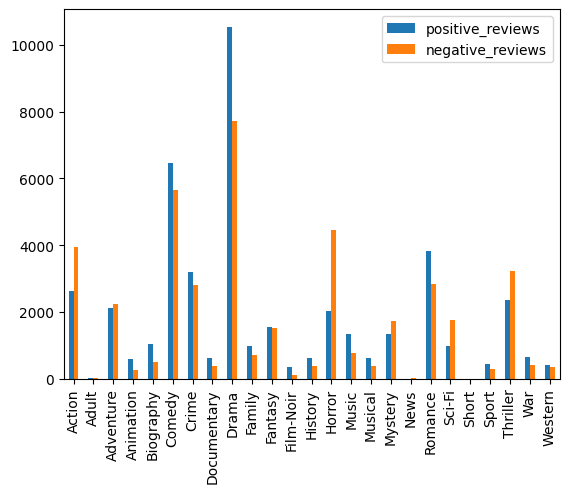

In [16]:
# Visualizar la relación entre reviews negativas vs reviews positivas
data = pd.DataFrame([[dict_genres[key][0], dict_genres[key][1]] for key in dict_genres.keys()],
                              columns=['positive_reviews', 'negative_reviews'], index=dict_genres.keys())

data.plot(kind = 'bar')

# Machine Learning model

In [14]:
#Obervamos los diferentes valores que estan en la columna label y si estos estan balanceados
df_movies['label'].value_counts()

Unsupervised    37883
Positive        18710
Negative        18161
Name: label, dtype: int64

In [15]:
#Para entrenar el modelo necesitamos unicamente las reviews con los datos etiquetados,
#los datos que dicen Unsupervised son usados para implementar modelos de machine learning no supervisados
#como no es nuestro caso, los eliminamos
data_model = df_movies[['review','label']].loc[df_movies['label']!='Unsupervised']

In [16]:
data_model.head()

review     label
0  hair, the movie based on the broadway hit,fail...  Negative
1  This film is an insult to the play upon which ...  Negative
2  I should start off by saying I have something ...  Negative
3  I've liked Milos Forman's movies since I saw "...  Negative
4  I was a hippie age 22 in 1965, have seen the p...  Negative

In [17]:
#observamos que el dataset se encuentra balanceado(Que la cantidad de valores de cada clase sean similares)
data_model['label'].value_counts()

Positive    18710
Negative    18161
Name: label, dtype: int64

In [18]:
#importamos la clase que creamos para procesar el dataset
from MLModelPreprocess import DataPreprocess

[nltk_data] Downloading package stopwords to C:\Users\Pablo
[nltk_data]     Tamayo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#inicializamos el objeto y realizamos el preprocesamiento del dataset
preprocess = DataPreprocess(data_model)

clean_text = preprocess.convert_data()

In [20]:
#Comparamos el texto antes y despues de ser procesado:
print(f'Texto procesado: {clean_text[1]}')
print('--------------')
print(f"Texto original: {data_model['review'][1]}")

Texto procesado: this film insult the play upon which base the charact claud has been warp beyond recognit leav pain perform that doe not even vagu resembl the origin plot shame shame shame they have also cut fair number the origin score chang the context which the song are sung this warp the air the film and caus the viewer who awar how this should winc the writer this screen play give hud wife turn sheila into spoil rich girl character claud cowboy and kill burger send him vietnam instead one not familiar with the origin plot assur you this not bad film for you see but you ever wish see the origin are die hard fan the classic play you would best avoid the film altogeth one realli must stick one the other
--------------
Texto original: This film is an insult to the play upon which it is based. The character of Claude has been warped beyond recognition leaving a painful performance that does not even vaguely resemble the original plot. Shame, shame, shame. They have also cut a fair num

In [21]:
# Vectorizamos el dataset, como resultado obtenemos una matriz con 2500 columnas
#  correspondientes a el numero de palabras distintas, cabe resaltar que el limite de 2500 lo pusimos nosotros 
# para no alargar el procesamiento.
# Vectorizer el el que vecroiza cada frase, nos servirá ára hacer puturas predicciones 
vectorizer, text_features = preprocess.vectroize_data(clean_text)


In [26]:
#dimensión de los datos que se entrenaran
print(text_features.shape)

(36871, 2500)


In [22]:
#division del dataset en entrenamiento y prueba: El dataset por defecto traia el mismo numero de train y test en la 
#columna split, por lo que ignoraremos esa notación y crearemos nuestro propio conjunto de entrenamiento y prueba
# tomando el 20% de los datos como test
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(text_features, data_model['label'], test_size=0.2, random_state=0)

In [23]:
# para el problema implementamos naive bayes, el cual tiene buen comportamiento en texto gracias
#  a la probabilidad condicional que implementa
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [31]:
predictions_train = nb.predict(X_train)
predictions_test = nb.predict(X_test)

print(f'Accuracy sobre el entrenamiento: {(accuracy_score(y_train, predictions_train)*100):.2f} %')
print(f'Accuracy sobre el test: {(accuracy_score(y_test, predictions_test)*100):.2f} %')
#Esto se hizo con el fin de saber si noestro modelo estaba sobre entrenado, pero vemos que como hay una similitud
#en los resultados de entrenamiento y prueba quiere decir que no es el caso.



Accuracy sobre el entrenamiento: 84.69 %
Accuracy sobre el test: 84.88 %


In [41]:
#creamos una funcion para realizar predicciones
def make_prediction(review, vectorizer_text=vectorizer, model_predict=nb, object_prepro=preprocess):
    '''
    Esta función recibe una review y retorna la polaridad (positiva o negativa)
    review: Review que será clasificada
    vectorizer_text: objeto que vectoriza la frase
    model_predict: modelo previamente entrenado que se usará para realizar la predicción
    object_prepro = objeto para preprocesar el texto

    return: polaridad de la review(positivo, negativo) 
    '''

    preprocessed_text = object_prepro.processing_text(review)
    text_vector = vectorizer_text.transform([preprocessed_text]).toarray()

    prediction = model_predict.predict(text_vector)

    return prediction

In [49]:
# probamos nuestro modelo con nuevas predicciones 
review_1 = 'This movie is horrible'
review_2 = 'this movie is awesome'

pred_1 = make_prediction(review_1)
pred_2 = make_prediction(review_2)
print(f'''
      Predicción review 1: {review_1} = {pred_1}
      Predicción review 2: {review_2} = {pred_2}
''')


      Predicción review 1: This movie is horrible = ['Negative']
      Predicción review 2: this movie is awesome = ['Positive']

